## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
random.seed(0)

#### Funciones a usar

In [2]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_crema_d(path):
    return path[119:122]


#Obtiene el codigo en el nombre del archivo para el dataset SAVEE
def get_code_savee(path):
    return path[108]


#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [3]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
    emotions_code = ["NEU", "FEA","ANG"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)
    files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
    emotions_code_s = ["a", "f","n"]
    datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 
    examples = []
    files_filters = dict()
    files_filters["NEU"] = 0
    files_filters["FEA"] = 0
    files_filters["ANG"] = 0
    files_filters["a"] = 0
    files_filters["f"] = 0
    files_filters["n"] = 0
    examples = get_features(datas_files, get_code_crema_d, files_filters)
    examples_s = get_features(datas_files_s, get_code_savee, files_filters)
    return examples + examples_s

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    '''
    datas = select_elements(entries, 'NEU', 896,"without_stress")
    datas += select_elements(entries, 'ANG', 550, "stress")
    datas += select_elements(entries, 'FEA', 550, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")
    '''
    '''
    datas = select_elements(entries, 'NEU', 1087,"without_stress")
    datas += select_elements(entries, 'ANG', 1271, "stress")
    datas += select_elements(entries, 'FEA', 1270, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")  
    '''
    datas = select_elements(entries, 'NEU', 1086,"without_stress")
    datas += select_elements(entries, 'ANG', 543, "stress")
    datas += select_elements(entries, 'FEA', 543, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.


In [10]:
X_train.shape

(1930, 40)

In [5]:
#funciones de redes neuronales
def previous_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

def new_RNN_a():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.7987477638640429
-----------------------
Resumen
Fold score (Accuracy score): 0.8102678571428571
Fold score (Accuracy score): 0.7516778523489933
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.8232662192393736
Fold score (Accuracy score): 0.8344519015659956
'''
def new_RNN_b():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8090339892665475
-----------------------
Resumen
Fold score (Accuracy score): 0.8214285714285714
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.8098434004474273
Fold score (Accuracy score): 0.8277404921700223
'''

def new_RNN_c():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7754919499105546
-----------------------
Resumen
Fold score (Accuracy score): 0.7879464285714286
Fold score (Accuracy score): 0.7539149888143176
Fold score (Accuracy score): 0.7718120805369127
Fold score (Accuracy score): 0.7628635346756152
Fold score (Accuracy score): 0.8008948545861297
'''

def double_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7920393559928444
-----------------------
Resumen
Fold score (Accuracy score): 0.78125
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.7941834451901566
Fold score (Accuracy score): 0.8165548098434005
'''

#fail tarda mucho
def triple_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7991949910554562
-----------------------
Resumen
Fold score (Accuracy score): 0.7991071428571429
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.814317673378076
Fold score (Accuracy score): 0.7762863534675615
Fold score (Accuracy score): 0.8210290827740492
'''
def dense_Layer():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dense(50))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7844364937388193
-----------------------
Resumen
Fold score (Accuracy score): 0.7589285714285714
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.796420581655481
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8076062639821029
'''

def possible_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.7898032200357782
-----------------------
Resumen
Fold score (Accuracy score): 0.7834821428571429
Fold score (Accuracy score): 0.8299776286353467
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.7472035794183445
Fold score (Accuracy score): 0.8210290827740492
'''
def activation_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.802772808586762
-----------------------
Resumen
Fold score (Accuracy score): 0.8080357142857143
Fold score (Accuracy score): 0.8076062639821029
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.8299776286353467
'''
def double_dropout():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    #model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8019136281355056
-----------------------
Resumen
Fold score (Accuracy score): 0.7945736434108527
Fold score (Accuracy score): 0.8036175710594315
Fold score (Accuracy score): 0.7800776196636481
Fold score (Accuracy score): 0.815006468305304
Fold score (Accuracy score): 0.8163001293661061
'''
def double_dropout_activation():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7944142746314973
-----------------------
Resumen
Fold score (Accuracy score): 0.7622739018087855
Fold score (Accuracy score): 0.810077519379845
Fold score (Accuracy score): 0.7865459249676585
Fold score (Accuracy score): 0.8020698576972833
Fold score (Accuracy score): 0.8111254851228978
'''
def double_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(LSTM(units=25,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.8057926040858546
-----------------------
Resumen
Fold score (Accuracy score): 0.7958656330749354
Fold score (Accuracy score): 0.789405684754522
Fold score (Accuracy score): 0.7878395860284605
Fold score (Accuracy score): 0.8279430789133247
Fold score (Accuracy score): 0.8279430789133247
'''

def basic():
    dropout = 0.5
    model = Sequential()
    model.add(LSTM(50,input_shape= dim_entrada))
    model.add(Dense(2,activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    return model
'''
Cross-validated score (Accuracy score): 0.8047582104990949
-----------------------
Resumen
Fold score (Accuracy score): 0.7984496124031008
Fold score (Accuracy score): 0.8126614987080103
Fold score (Accuracy score): 0.7813712807244502
Fold score (Accuracy score): 0.8227684346701164
Fold score (Accuracy score): 0.8085381630012937

'''

def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units=10,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
model = Sequential()
model.add(layers.Embedding(input_dim=20000, 
                           output_dim=100, 
                           input_length=300))
model.add(layers.Bidirectional(layers.LSTM(100, dropout=0.5, 
                                           recurrent_dropout=0.5, 
                                           return_sequences=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()
'''
'''
Cross-validated score (Accuracy score): 0.7929338103756708
-----------------------
Resumen
Fold score (Accuracy score): 0.7901785714285714
Fold score (Accuracy score): 0.8277404921700223
Fold score (Accuracy score): 0.7897091722595079
Fold score (Accuracy score): 0.7472035794183445
Fold score (Accuracy score): 0.8098434004474273
2
#https://keras.io/api/callbacks/early_stopping/
'''


'\nCross-validated score (Accuracy score): 0.7929338103756708\n-----------------------\nResumen\nFold score (Accuracy score): 0.7901785714285714\nFold score (Accuracy score): 0.8277404921700223\nFold score (Accuracy score): 0.7897091722595079\nFold score (Accuracy score): 0.7472035794183445\nFold score (Accuracy score): 0.8098434004474273\n2\n#https://keras.io/api/callbacks/early_stopping/\n'

In [6]:
model = new_RNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            10400     
                                                                 
 activation (Activation)     (None, 40, 50)            0         
                                                                 
 dropout (Dropout)           (None, 40, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 20)            5680      
                                                                 
 activation_1 (Activation)   (None, 40, 20)            0         
                                                                 
 dropout_1 (Dropout)         (None, 40, 20)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                1

In [21]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 200
    num_batch_size = 32
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(1929, 40) y:(1929, 2)
Test - X:(483, 40) y:(483, 2)
Epoch 1/200
61/61 [==============================] - 37s 108ms/step - loss: 0.6853 - accuracy: 0.5397 - val_loss: 0.6624 - val_accuracy: 0.6398
Epoch 2/200
61/61 [==============================] - 5s 74ms/step - loss: 0.6316 - accuracy: 0.6376 - val_loss: 0.5840 - val_accuracy: 0.6915
Epoch 3/200
61/61 [==============================] - 4s 68ms/step - loss: 0.6124 - accuracy: 0.6672 - val_loss: 0.5734 - val_accuracy: 0.7101
Epoch 4/200
61/61 [==============================] - 4s 70ms/step - loss: 0.6126 - accuracy: 0.6563 - val_loss: 0.5694 - val_accuracy: 0.7205
Epoch 5/200
61/61 [==============================] - 4s 66ms/step - loss: 0.5872 - accuracy: 0.7055 - val_loss: 0.5467 - val_accuracy: 0.7143
Epoch 6/200
61/61 [==============================] - 4s 74ms/step - loss: 0.5752 - accuracy: 0.6890 - val_loss: 0.5412 - val_accuracy: 0.7433
Epoch 7/200
61/61 [==============================] - 5s 85ms/step - loss: 0

Epoch 58/200
61/61 [==============================] - 5s 88ms/step - loss: 0.4342 - accuracy: 0.7911 - val_loss: 0.3776 - val_accuracy: 0.8219
Epoch 59/200
61/61 [==============================] - 5s 87ms/step - loss: 0.4318 - accuracy: 0.7957 - val_loss: 0.3829 - val_accuracy: 0.8137
Epoch 60/200
61/61 [==============================] - 6s 93ms/step - loss: 0.4384 - accuracy: 0.7900 - val_loss: 0.3935 - val_accuracy: 0.8157
Epoch 61/200
61/61 [==============================] - 6s 90ms/step - loss: 0.4224 - accuracy: 0.8004 - val_loss: 0.3952 - val_accuracy: 0.8302
Epoch 62/200
61/61 [==============================] - 6s 91ms/step - loss: 0.4476 - accuracy: 0.7921 - val_loss: 0.4042 - val_accuracy: 0.8178
Epoch 63/200
61/61 [==============================] - 5s 90ms/step - loss: 0.4243 - accuracy: 0.7983 - val_loss: 0.4574 - val_accuracy: 0.7764
Epoch 64/200
61/61 [==============================] - 5s 90ms/step - loss: 0.4375 - accuracy: 0.7942 - val_loss: 0.4212 - val_accuracy: 0.8219

Epoch 172/200
61/61 [==============================] - 6s 95ms/step - loss: 0.2736 - accuracy: 0.8849 - val_loss: 0.6518 - val_accuracy: 0.8509
Epoch 173/200
61/61 [==============================] - 6s 92ms/step - loss: 0.2859 - accuracy: 0.8792 - val_loss: 0.4700 - val_accuracy: 0.8261
Epoch 174/200
61/61 [==============================] - 6s 91ms/step - loss: 0.2847 - accuracy: 0.8740 - val_loss: 0.7866 - val_accuracy: 0.8427
Epoch 175/200
61/61 [==============================] - 5s 89ms/step - loss: 0.3100 - accuracy: 0.8647 - val_loss: 0.5039 - val_accuracy: 0.7971
Epoch 176/200
61/61 [==============================] - 6s 103ms/step - loss: 0.3145 - accuracy: 0.8605 - val_loss: 0.6609 - val_accuracy: 0.8406
Epoch 177/200
61/61 [==============================] - 6s 95ms/step - loss: 0.2854 - accuracy: 0.8792 - val_loss: 0.5090 - val_accuracy: 0.8406
Epoch 178/200
61/61 [==============================] - 6s 91ms/step - loss: 0.2668 - accuracy: 0.8917 - val_loss: 0.5804 - val_accuracy

Epoch 27/200
61/61 [==============================] - 6s 94ms/step - loss: 0.5050 - accuracy: 0.7470 - val_loss: 0.5091 - val_accuracy: 0.7391
Epoch 28/200
61/61 [==============================] - 6s 101ms/step - loss: 0.4809 - accuracy: 0.7564 - val_loss: 0.4874 - val_accuracy: 0.7516
Epoch 29/200
61/61 [==============================] - 6s 94ms/step - loss: 0.4735 - accuracy: 0.7760 - val_loss: 0.5003 - val_accuracy: 0.7557
Epoch 30/200
61/61 [==============================] - 6s 99ms/step - loss: 0.4756 - accuracy: 0.7698 - val_loss: 0.4923 - val_accuracy: 0.7433
Epoch 31/200
61/61 [==============================] - 6s 94ms/step - loss: 0.4783 - accuracy: 0.7646 - val_loss: 0.4960 - val_accuracy: 0.7453
Epoch 32/200
61/61 [==============================] - 6s 101ms/step - loss: 0.4949 - accuracy: 0.7569 - val_loss: 0.4793 - val_accuracy: 0.7640
Epoch 33/200
61/61 [==============================] - 6s 93ms/step - loss: 0.4664 - accuracy: 0.7895 - val_loss: 0.4885 - val_accuracy: 0.74

Epoch 141/200
61/61 [==============================] - 5s 85ms/step - loss: 0.2981 - accuracy: 0.8605 - val_loss: 0.5593 - val_accuracy: 0.7867
Epoch 142/200
61/61 [==============================] - 5s 84ms/step - loss: 0.3000 - accuracy: 0.8621 - val_loss: 0.4782 - val_accuracy: 0.7950
Epoch 143/200
61/61 [==============================] - 5s 84ms/step - loss: 0.3135 - accuracy: 0.8585 - val_loss: 0.5029 - val_accuracy: 0.7619
Epoch 144/200
61/61 [==============================] - 5s 85ms/step - loss: 0.3205 - accuracy: 0.8621 - val_loss: 0.4935 - val_accuracy: 0.7764
Epoch 145/200
61/61 [==============================] - 5s 83ms/step - loss: 0.2967 - accuracy: 0.8590 - val_loss: 0.5011 - val_accuracy: 0.7930
Epoch 146/200
61/61 [==============================] - 5s 84ms/step - loss: 0.2946 - accuracy: 0.8657 - val_loss: 0.4423 - val_accuracy: 0.8054
Epoch 147/200
61/61 [==============================] - 5s 84ms/step - loss: 0.2908 - accuracy: 0.8663 - val_loss: 0.6065 - val_accuracy:

Epoch 198/200
61/61 [==============================] - 4s 73ms/step - loss: 0.2065 - accuracy: 0.9082 - val_loss: 0.6557 - val_accuracy: 0.7992
Epoch 199/200
61/61 [==============================] - 6s 98ms/step - loss: 0.2048 - accuracy: 0.9062 - val_loss: 0.7715 - val_accuracy: 0.7888
Epoch 200/200
16/16 [==============================] - 3s 23ms/step
Fold score (Accuracy score): 0.8074534161490683
Matriz de confusion
-------------------
---------| Verdadero | Falso |
Verdadero|  163        15
Falso    |  78        227
Fold #3
Train - X:(1930, 40) y:(1930, 2)
Test - X:(482, 40) y:(482, 2)
Epoch 1/200
61/61 [==============================] - 21s 145ms/step - loss: 0.6864 - accuracy: 0.5409 - val_loss: 0.6593 - val_accuracy: 0.6577
Epoch 2/200
61/61 [==============================] - 5s 87ms/step - loss: 0.6431 - accuracy: 0.6368 - val_loss: 0.5978 - val_accuracy: 0.7033
Epoch 3/200
61/61 [==============================] - 5s 87ms/step - loss: 0.6112 - accuracy: 0.6725 - val_loss: 0.55

61/61 [==============================] - 5s 89ms/step - loss: 0.4043 - accuracy: 0.7927 - val_loss: 0.4232 - val_accuracy: 0.8257
Epoch 111/200
61/61 [==============================] - 5s 86ms/step - loss: 0.3578 - accuracy: 0.8295 - val_loss: 0.4187 - val_accuracy: 0.8091
Epoch 112/200
61/61 [==============================] - 5s 90ms/step - loss: 0.3424 - accuracy: 0.8363 - val_loss: 0.4761 - val_accuracy: 0.8154
Epoch 113/200
61/61 [==============================] - 6s 90ms/step - loss: 0.3382 - accuracy: 0.8337 - val_loss: 0.4273 - val_accuracy: 0.8216
Epoch 114/200
61/61 [==============================] - 5s 88ms/step - loss: 0.3433 - accuracy: 0.8280 - val_loss: 0.4511 - val_accuracy: 0.8195
Epoch 115/200
61/61 [==============================] - 5s 89ms/step - loss: 0.3475 - accuracy: 0.8373 - val_loss: 0.4279 - val_accuracy: 0.8340
Epoch 116/200
61/61 [==============================] - 6s 91ms/step - loss: 0.3532 - accuracy: 0.8269 - val_loss: 0.4072 - val_accuracy: 0.8257
Epoch 

Epoch 167/200
61/61 [==============================] - 5s 77ms/step - loss: 0.3265 - accuracy: 0.8544 - val_loss: 0.5081 - val_accuracy: 0.8112
Epoch 168/200
61/61 [==============================] - 5s 80ms/step - loss: 0.2645 - accuracy: 0.8793 - val_loss: 0.6157 - val_accuracy: 0.8091
Epoch 169/200
61/61 [==============================] - 5s 87ms/step - loss: 0.2530 - accuracy: 0.8819 - val_loss: 0.5408 - val_accuracy: 0.8237
Epoch 170/200
61/61 [==============================] - 5s 84ms/step - loss: 0.2331 - accuracy: 0.8881 - val_loss: 0.5543 - val_accuracy: 0.8299
Epoch 171/200
61/61 [==============================] - 6s 91ms/step - loss: 0.2833 - accuracy: 0.8772 - val_loss: 0.5017 - val_accuracy: 0.8050
Epoch 172/200
61/61 [==============================] - 5s 88ms/step - loss: 0.3364 - accuracy: 0.8482 - val_loss: 0.5085 - val_accuracy: 0.8112
Epoch 173/200
61/61 [==============================] - 5s 85ms/step - loss: 0.2512 - accuracy: 0.8927 - val_loss: 0.5084 - val_accuracy:

Epoch 22/200
61/61 [==============================] - 6s 102ms/step - loss: 0.5499 - accuracy: 0.7373 - val_loss: 0.5139 - val_accuracy: 0.7386
Epoch 23/200
61/61 [==============================] - 6s 106ms/step - loss: 0.5311 - accuracy: 0.7404 - val_loss: 0.4864 - val_accuracy: 0.7635
Epoch 24/200
61/61 [==============================] - 5s 83ms/step - loss: 0.5308 - accuracy: 0.7456 - val_loss: 0.5279 - val_accuracy: 0.7324
Epoch 25/200
61/61 [==============================] - 6s 96ms/step - loss: 0.5420 - accuracy: 0.7394 - val_loss: 0.5083 - val_accuracy: 0.7448
Epoch 26/200
61/61 [==============================] - 6s 94ms/step - loss: 0.5301 - accuracy: 0.7482 - val_loss: 0.4767 - val_accuracy: 0.7718
Epoch 27/200
61/61 [==============================] - 6s 103ms/step - loss: 0.5293 - accuracy: 0.7446 - val_loss: 0.4733 - val_accuracy: 0.7801
Epoch 28/200
61/61 [==============================] - 6s 99ms/step - loss: 0.5117 - accuracy: 0.7440 - val_loss: 0.5046 - val_accuracy: 0.7

Epoch 136/200
61/61 [==============================] - 6s 90ms/step - loss: 0.2706 - accuracy: 0.9114 - val_loss: 0.5068 - val_accuracy: 0.8071
Epoch 137/200
61/61 [==============================] - 5s 88ms/step - loss: 0.2659 - accuracy: 0.9010 - val_loss: 0.5719 - val_accuracy: 0.7946
Epoch 138/200
61/61 [==============================] - 5s 85ms/step - loss: 0.2745 - accuracy: 0.8943 - val_loss: 0.4921 - val_accuracy: 0.8237
Epoch 139/200
61/61 [==============================] - 5s 84ms/step - loss: 0.2411 - accuracy: 0.9171 - val_loss: 0.5266 - val_accuracy: 0.8133
Epoch 140/200
61/61 [==============================] - 6s 101ms/step - loss: 0.2409 - accuracy: 0.9109 - val_loss: 0.5153 - val_accuracy: 0.8133
Epoch 141/200
61/61 [==============================] - 6s 103ms/step - loss: 0.2762 - accuracy: 0.9021 - val_loss: 0.6378 - val_accuracy: 0.7635
Epoch 142/200
61/61 [==============================] - 6s 97ms/step - loss: 0.3314 - accuracy: 0.8694 - val_loss: 0.4853 - val_accurac

Epoch 193/200
61/61 [==============================] - 5s 84ms/step - loss: 0.1576 - accuracy: 0.9430 - val_loss: 0.8455 - val_accuracy: 0.8091
Epoch 194/200
61/61 [==============================] - 5s 88ms/step - loss: 0.1728 - accuracy: 0.9368 - val_loss: 0.9270 - val_accuracy: 0.8050
Epoch 195/200
61/61 [==============================] - 5s 79ms/step - loss: 0.1640 - accuracy: 0.9451 - val_loss: 0.8831 - val_accuracy: 0.7884
Epoch 196/200
61/61 [==============================] - 6s 91ms/step - loss: 0.2275 - accuracy: 0.9078 - val_loss: 0.7049 - val_accuracy: 0.7801
Epoch 197/200
61/61 [==============================] - 6s 100ms/step - loss: 0.1687 - accuracy: 0.9378 - val_loss: 0.7964 - val_accuracy: 0.7925
Epoch 198/200
61/61 [==============================] - 6s 101ms/step - loss: 0.1336 - accuracy: 0.9518 - val_loss: 0.8516 - val_accuracy: 0.7946
Epoch 199/200
61/61 [==============================] - 6s 96ms/step - loss: 0.1309 - accuracy: 0.9580 - val_loss: 0.8922 - val_accurac

Epoch 48/200
61/61 [==============================] - 7s 123ms/step - loss: 0.4476 - accuracy: 0.7793 - val_loss: 0.4615 - val_accuracy: 0.7448
Epoch 49/200
61/61 [==============================] - 8s 127ms/step - loss: 0.4493 - accuracy: 0.7808 - val_loss: 0.4391 - val_accuracy: 0.7635
Epoch 50/200
61/61 [==============================] - 8s 130ms/step - loss: 0.4420 - accuracy: 0.7948 - val_loss: 0.5406 - val_accuracy: 0.7407
Epoch 51/200
61/61 [==============================] - 8s 130ms/step - loss: 0.4489 - accuracy: 0.7896 - val_loss: 0.4220 - val_accuracy: 0.7676
Epoch 52/200
61/61 [==============================] - 8s 126ms/step - loss: 0.4202 - accuracy: 0.8005 - val_loss: 0.4269 - val_accuracy: 0.7759
Epoch 53/200
61/61 [==============================] - 8s 129ms/step - loss: 0.4326 - accuracy: 0.8021 - val_loss: 0.4186 - val_accuracy: 0.7801
Epoch 54/200
61/61 [==============================] - 8s 131ms/step - loss: 0.4207 - accuracy: 0.8062 - val_loss: 0.4166 - val_accuracy:

Epoch 105/200
61/61 [==============================] - 8s 136ms/step - loss: 0.3320 - accuracy: 0.8451 - val_loss: 0.4569 - val_accuracy: 0.8133
Epoch 106/200
61/61 [==============================] - 8s 130ms/step - loss: 0.3566 - accuracy: 0.8218 - val_loss: 0.4507 - val_accuracy: 0.8008
Epoch 107/200
61/61 [==============================] - 9s 140ms/step - loss: 0.3063 - accuracy: 0.8523 - val_loss: 0.4311 - val_accuracy: 0.8029
Epoch 108/200
61/61 [==============================] - 9s 140ms/step - loss: 0.3133 - accuracy: 0.8492 - val_loss: 0.4473 - val_accuracy: 0.8050
Epoch 109/200
61/61 [==============================] - 9s 147ms/step - loss: 0.3068 - accuracy: 0.8539 - val_loss: 0.4344 - val_accuracy: 0.8174
Epoch 110/200
61/61 [==============================] - 9s 149ms/step - loss: 0.3180 - accuracy: 0.8456 - val_loss: 0.4864 - val_accuracy: 0.7925
Epoch 111/200
61/61 [==============================] - 9s 153ms/step - loss: 0.3047 - accuracy: 0.8601 - val_loss: 0.4386 - val_ac

In [22]:
#50 0.77
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]

num_epochs = 100
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 40, 50)            10400     
                                                                 
 activation_21 (Activation)  (None, 40, 50)            0         
                                                                 
 dropout_21 (Dropout)        (None, 40, 50)            0         
                                                                 
 lstm_22 (LSTM)              (None, 40, 20)            5680      
                                                                 
 activation_22 (Activation)  (None, 40, 20)            0         
                                                                 
 dropout_22 (Dropout)        (None, 40, 20)            0         
                                                                 
 lstm_23 (LSTM)              (None, 10)               

Epoch 46/100
61/61 [==============================] - 10s 169ms/step - loss: 0.4491 - accuracy: 0.7824 - val_loss: 0.5368 - val_accuracy: 0.7573
Epoch 47/100
61/61 [==============================] - 10s 159ms/step - loss: 0.4372 - accuracy: 0.7948 - val_loss: 0.5190 - val_accuracy: 0.7158
Epoch 48/100
61/61 [==============================] - 8s 139ms/step - loss: 0.4595 - accuracy: 0.7777 - val_loss: 0.5004 - val_accuracy: 0.7531
Epoch 49/100
61/61 [==============================] - 8s 139ms/step - loss: 0.4526 - accuracy: 0.7850 - val_loss: 0.4928 - val_accuracy: 0.7552
Epoch 50/100
61/61 [==============================] - 9s 140ms/step - loss: 0.4330 - accuracy: 0.7870 - val_loss: 0.4768 - val_accuracy: 0.7573
Epoch 51/100
61/61 [==============================] - 8s 126ms/step - loss: 0.4318 - accuracy: 0.7938 - val_loss: 0.4922 - val_accuracy: 0.7490
Epoch 52/100
61/61 [==============================] - 8s 136ms/step - loss: 0.4518 - accuracy: 0.7886 - val_loss: 0.5336 - val_accurac

In [32]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

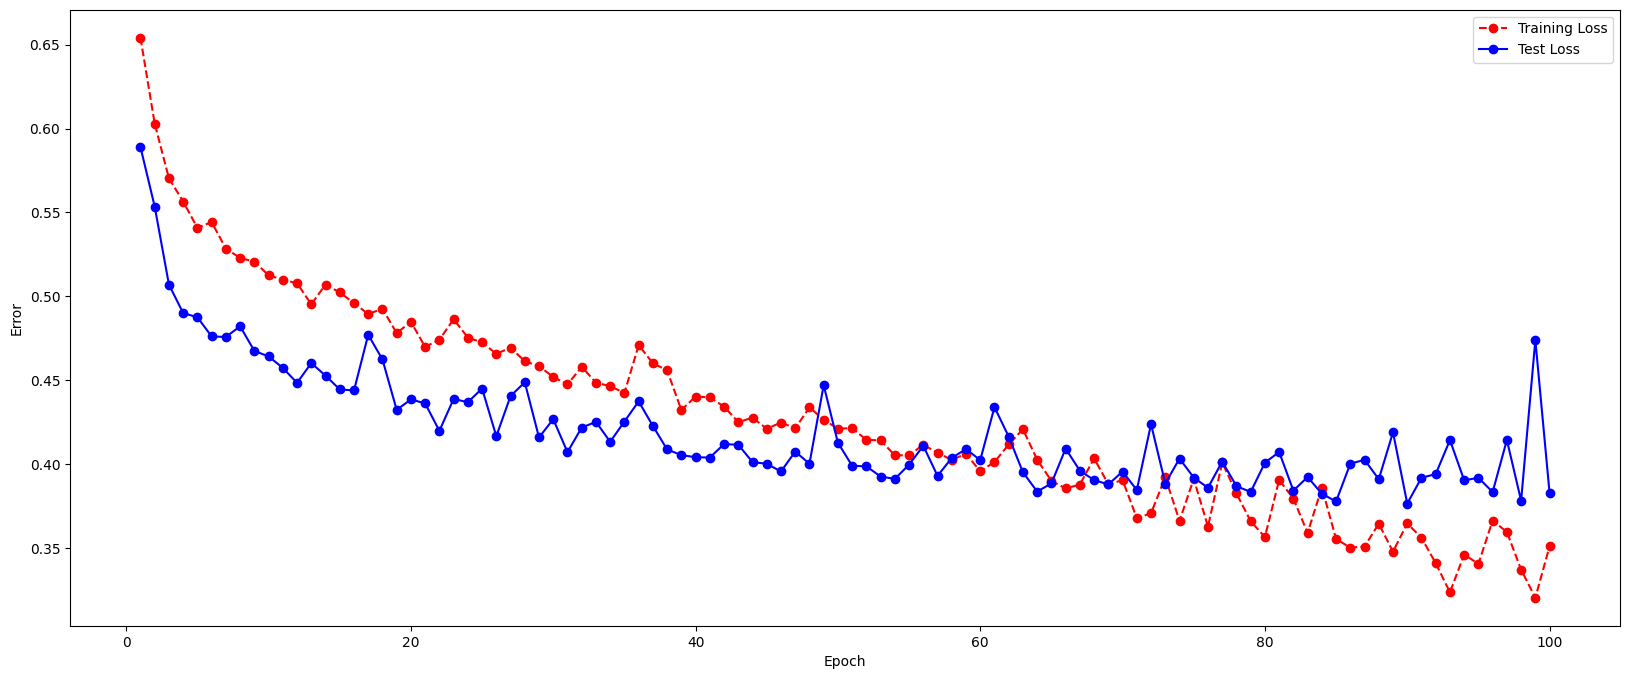

In [33]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [14]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.40328726172447205 val_accuracy: 0.8150064945220947


NameError: name 'y_values' is not defined

In [77]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
